Adapted from [Image Processing Cookbook](https://github.com/PacktPublishing/Python-Image-Processing-Cookbook) 

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gabor_kernel
from glob import glob
from scipy import ndimage as ndi

In [0]:
!git clone https://github.com/PacktPublishing/Python-Image-Processing-Cookbook.git

Cloning into 'Python-Image-Processing-Cookbook'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 2642 (delta 24), reused 28 (delta 11), pack-reused 2592
Receiving objects: 100% (2642/2642), 1.25 GiB | 34.86 MiB/s, done.
Resolving deltas: 100% (493/493), done.
Checking out files: 100% (1078/1078), done.


In [0]:
IMAGE_DIR = '/content/Python-Image-Processing-Cookbook/Chapter 07/images/'

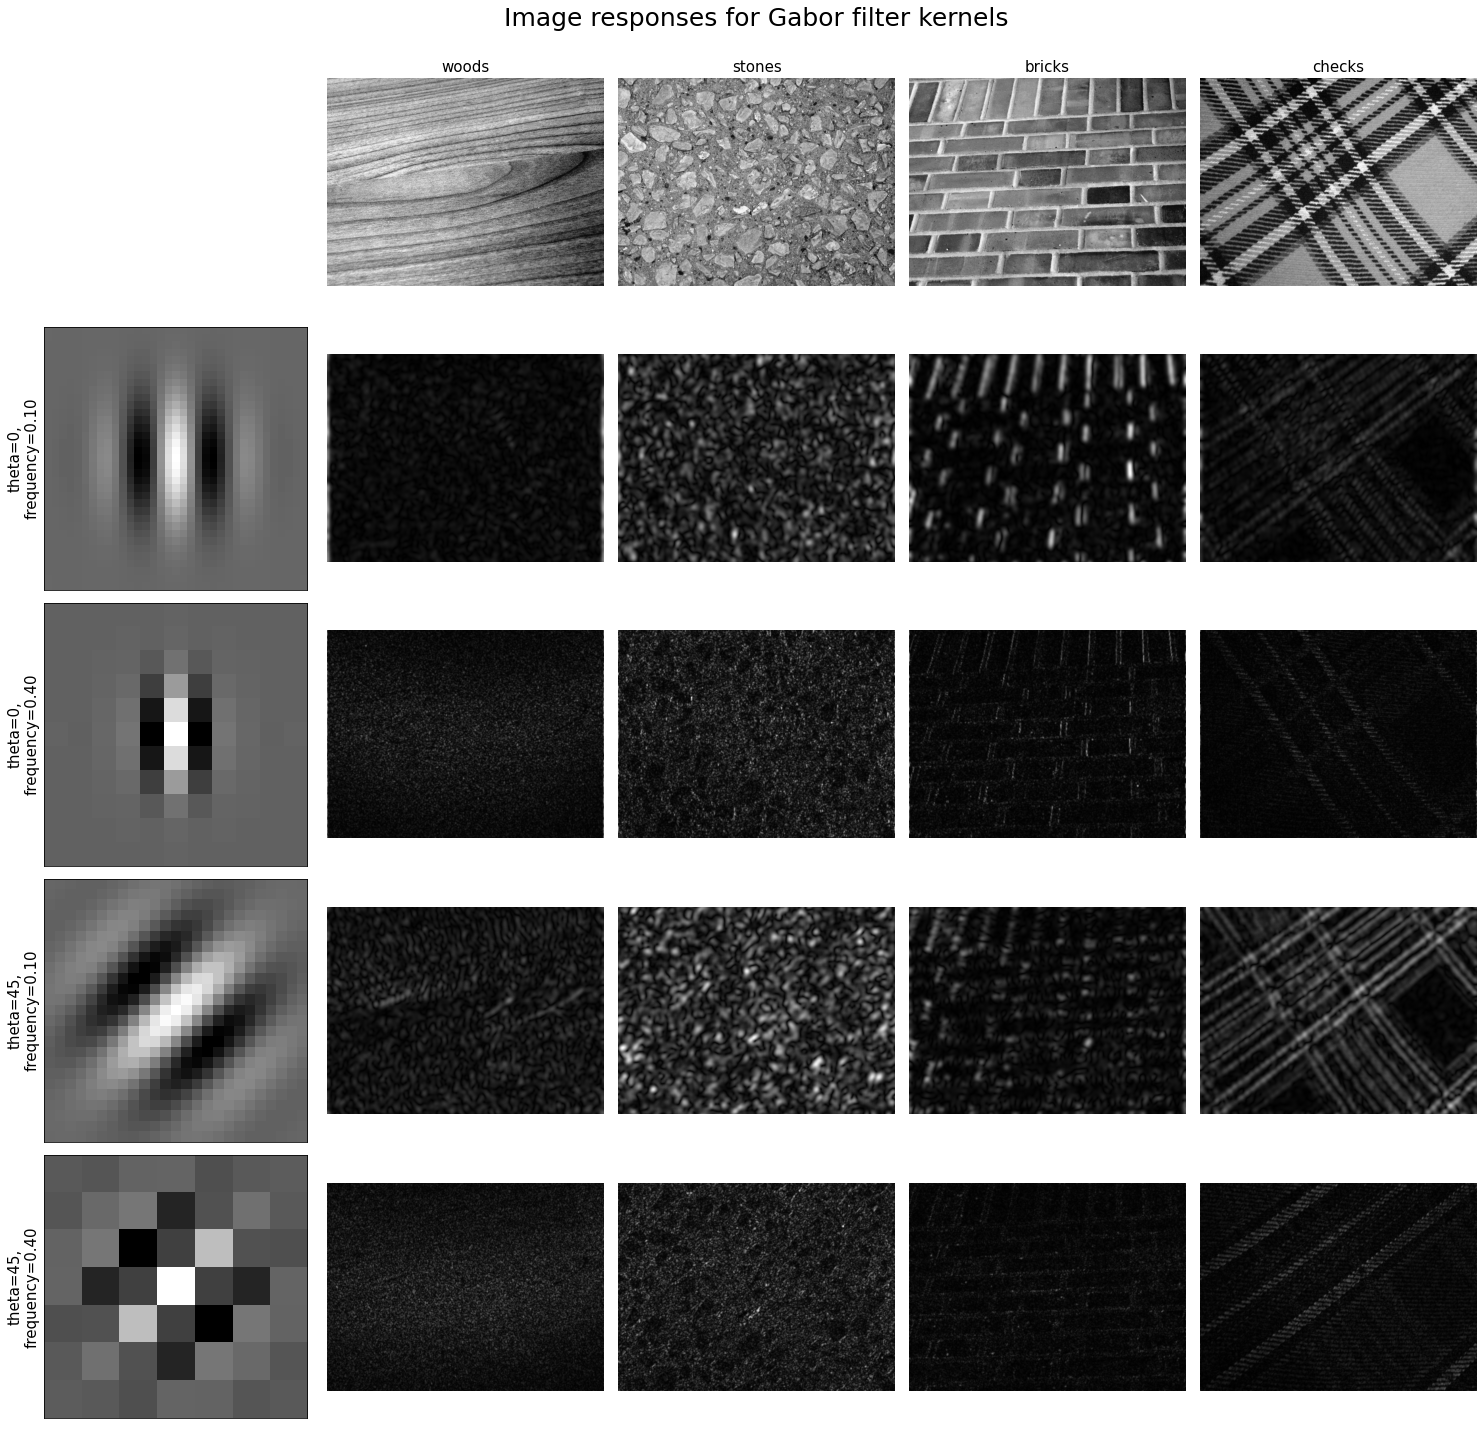

In [0]:
# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

image_names = [IMAGE_DIR+'UIUC_textures/woods/T04_01.jpg',
               IMAGE_DIR+'UIUC_textures/stones/T12_01.jpg',
               IMAGE_DIR+'UIUC_textures/bricks/T15_01.jpg',
               IMAGE_DIR+'UIUC_textures/checks/T25_01.jpg',
              ]
labels = ['woods', 'stones', 'bricks', 'checks']

images = []
for image_name in image_names:
    images.append(rgb2gray(imread(image_name)))

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
fig.suptitle('Image responses for Gabor filter kernels', fontsize=25)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(labels, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=15)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

Images matched against references using Gabor filter banks:
original: woods, match result: woods 
original: stones, match result: stones 
original: bricks, match result: bricks 
original: checks, match result: checks 


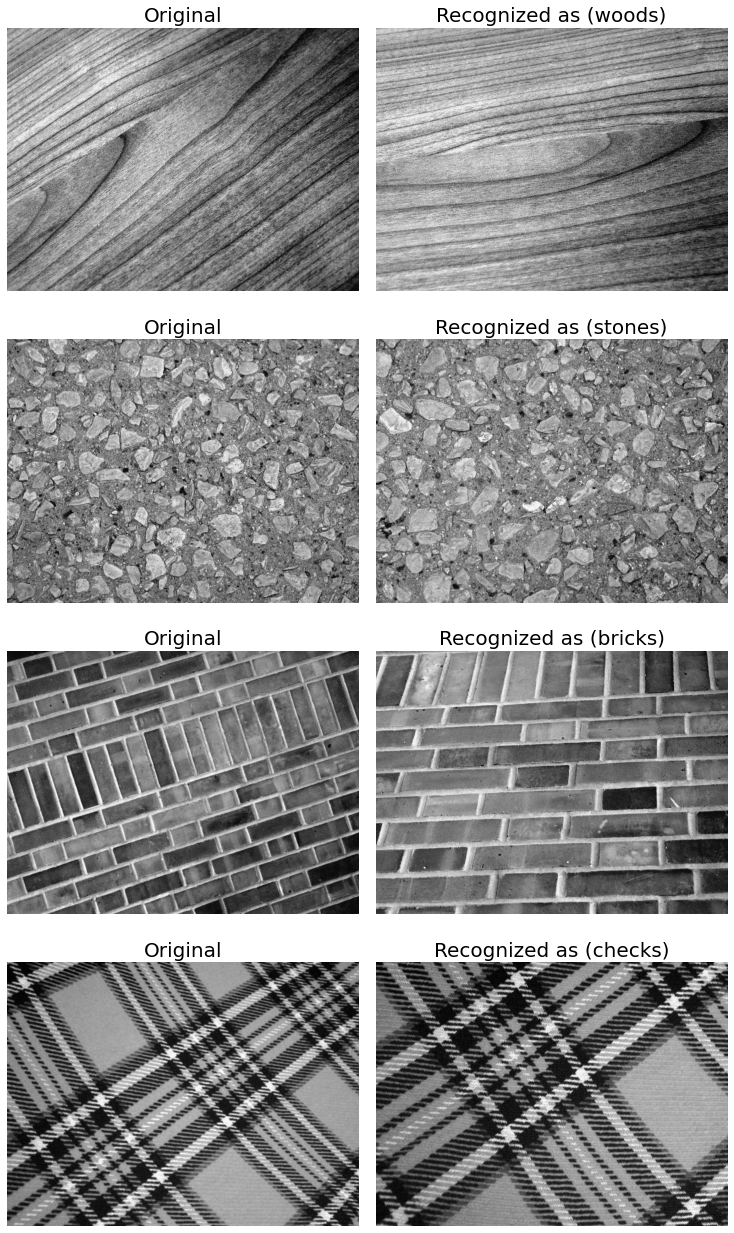

In [0]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i

# prepare reference features
ref_feats = np.zeros((4, len(kernels), 2), dtype=np.double)
for i in range(4):
    ref_feats[i, :, :] = compute_feats(images[i], kernels)

print('Images matched against references using Gabor filter banks:')

new_image_names = [IMAGE_DIR + 'UIUC_textures/woods/T04_02.jpg',
               IMAGE_DIR + 'UIUC_textures/stones/T12_02.jpg',
               IMAGE_DIR + 'UIUC_textures/bricks/T15_02.jpg',
               IMAGE_DIR + 'UIUC_textures/checks/T25_02.jpg',
              ]

plt.figure(figsize=(10,18))
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
for i in range(4):
    image = rgb2gray(imread(new_image_names[i]))
    feats = compute_feats(image, kernels)
    mindex = match(feats, ref_feats)
    print('original: {}, match result: {} '.format(labels[i], labels[mindex]))
    plt.subplot(4,2,2*i+1), plt.imshow(image), plt.axis('off'), plt.title('Original', size=20)
    plt.subplot(4,2,2*i+2), plt.imshow(images[mindex]), plt.axis('off'), plt.title('Recognized as ({})'.format(labels[mindex]), size=20)
plt.show()